In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
seed = 13
batch_size = 16
target_size = (256, 256)

def image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        img = img/255
        mask = to_categorical(mask)
        yield (img, mask)
        
def create_generator_pair(img_path, mask_path):
    image_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    image_data_generator = image_data_generator.flow_from_directory(img_path, 
                                                                    class_mode=None, 
                                                                    batch_size=batch_size, 
                                                                    target_size=target_size, 
                                                                    seed=seed)
    
    mask_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    mask_data_generator = mask_data_generator.flow_from_directory(mask_path, 
                                                                  class_mode=None, 
                                                                  color_mode='grayscale', 
                                                                  batch_size=batch_size, 
                                                                  target_size=target_size, 
                                                                  seed=seed)
    
    return image_data_generator, mask_data_generator

In [3]:
img_train_path = 'D:\documents\master_dataset_2\\train_images'
mask_train_path = 'D:\documents\master_dataset_2\\train_masks'
train_generator = image_mask_generator(*create_generator_pair(img_train_path, mask_train_path))

img_val_path = 'D:\documents\master_dataset_2\\val_images'
mask_val_path = 'D:\documents\master_dataset_2\\val_masks'
val_generator = image_mask_generator(*create_generator_pair(img_val_path, mask_val_path))

Found 1789 images belonging to 1 classes.
Found 1789 images belonging to 1 classes.
Found 449 images belonging to 1 classes.
Found 449 images belonging to 1 classes.


In [4]:
num_train_imgs = len(os.listdir('D:\documents\master_dataset_2\\train_images\img'))
num_val_images = len(os.listdir('D:\documents\master_dataset_2\\val_images\img'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

### Sanity check

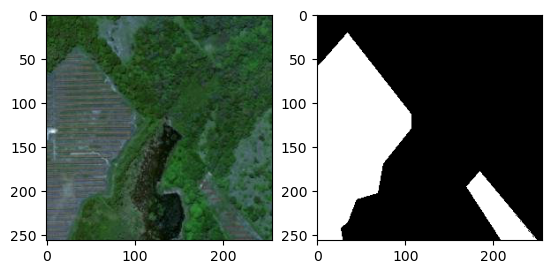

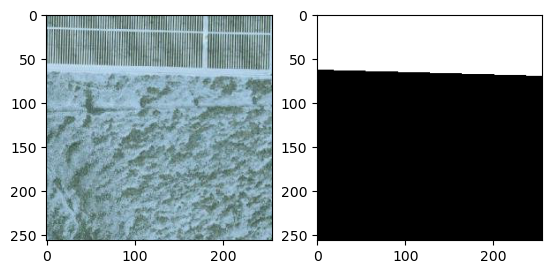

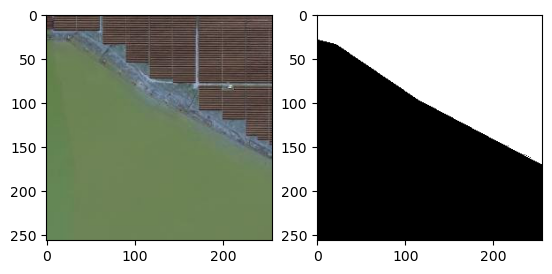

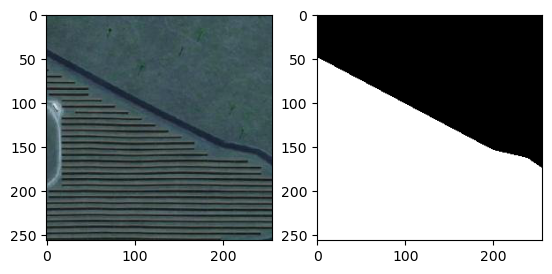

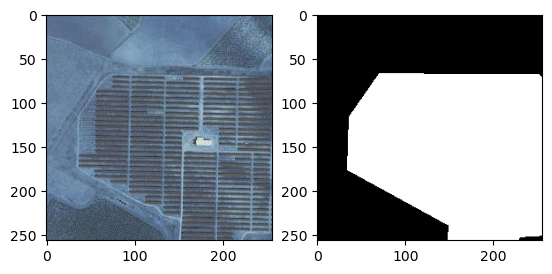

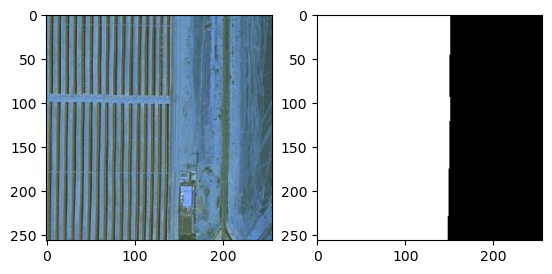

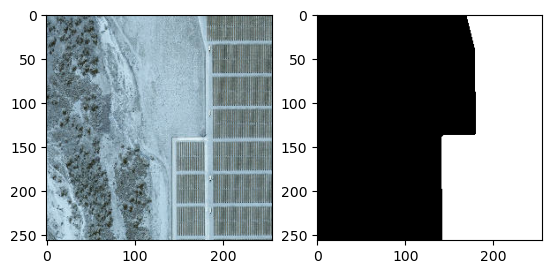

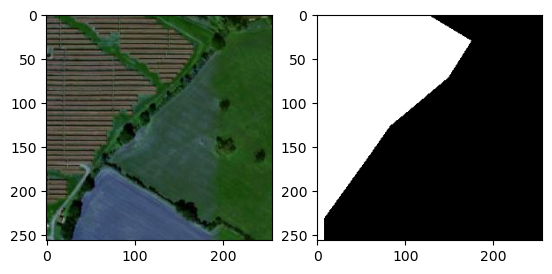

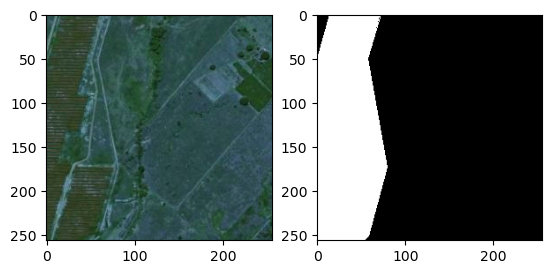

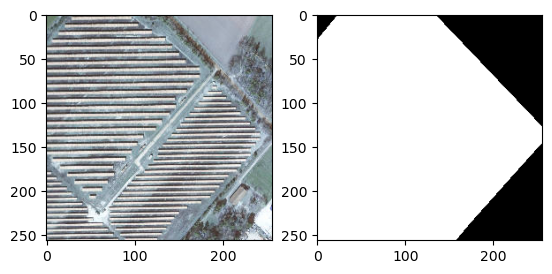

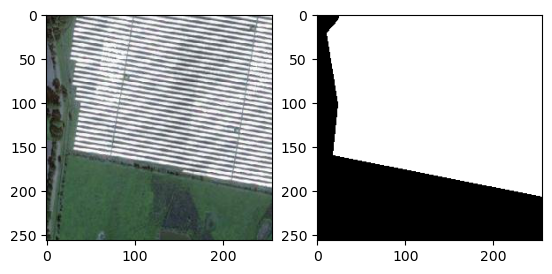

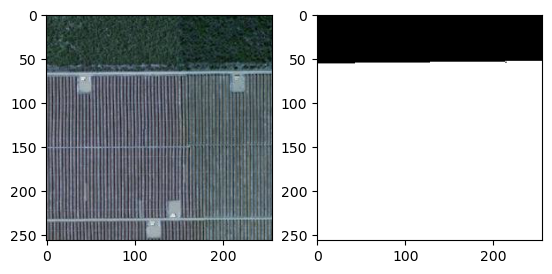

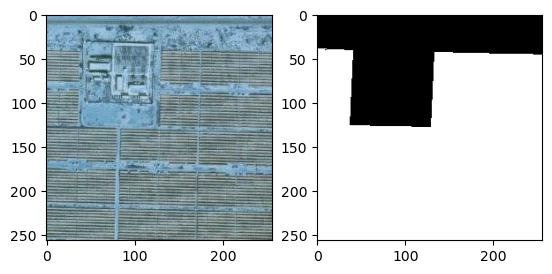

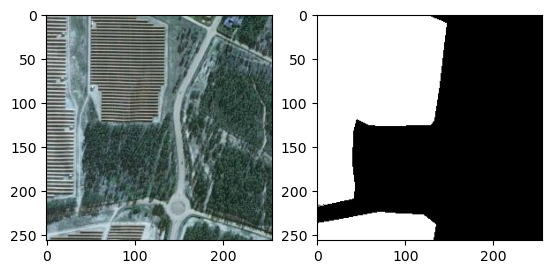

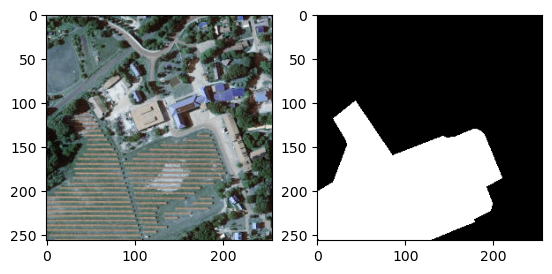

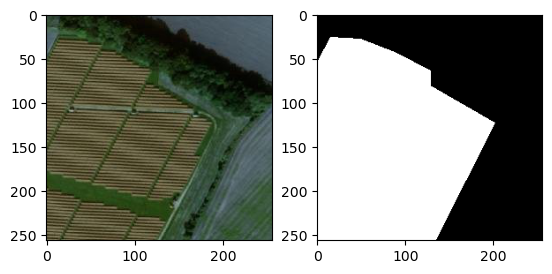

In [5]:
for img, mask in zip(*next(train_generator)):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img)
    axarr[1].imshow(np.argmax(mask, axis=2), cmap='gray')
    plt.show()

### Model creation

In [6]:
model = sm.Unet('resnet34', input_shape=(256,256,3), classes=2, activation='softmax')
model.compile(optimizer='adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())
print(model.input_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

### Model training

In [7]:
filepath = "D:\documents\master_dataset_2\saved-model-{epoch:02d}-unet_backbone_resnet34.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=False, mode='max')

history = model.fit(train_generator, epochs=30, steps_per_epoch=steps_per_epoch, verbose=2, 
                    validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                    callbacks=[checkpoint])

Epoch 1/30
111/111 - 148s - loss: 0.2167 - iou_score: 0.8070 - val_loss: 1.0484 - val_iou_score: 0.2082

Epoch 00001: saving model to D:\documents\master_dataset_2\saved-model-01-unet_backbone_resnet34.hdf5


C:\Users\Filip\Anaconda3\envs\master_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
111/111 - 79s - loss: 0.1415 - iou_score: 0.8821 - val_loss: 0.8618 - val_iou_score: 0.3121

Epoch 00002: saving model to D:\documents\master_dataset_2\saved-model-02-unet_backbone_resnet34.hdf5
Epoch 3/30
111/111 - 79s - loss: 0.1207 - iou_score: 0.8997 - val_loss: 0.8419 - val_iou_score: 0.3248

Epoch 00003: saving model to D:\documents\master_dataset_2\saved-model-03-unet_backbone_resnet34.hdf5
Epoch 4/30
111/111 - 102s - loss: 0.1221 - iou_score: 0.8989 - val_loss: 0.9547 - val_iou_score: 0.3103

Epoch 00004: saving model to D:\documents\master_dataset_2\saved-model-04-unet_backbone_resnet34.hdf5
Epoch 5/30
111/111 - 82s - loss: 0.1150 - iou_score: 0.9046 - val_loss: 0.8049 - val_iou_score: 0.3048

Epoch 00005: saving model to D:\documents\master_dataset_2\saved-model-05-unet_backbone_resnet34.hdf5
Epoch 6/30
111/111 - 81s - loss: 0.1065 - iou_score: 0.9114 - val_loss: 0.9800 - val_iou_score: 0.3506

Epoch 00006: saving model to D:\documents\master_dataset_2\saved-model-

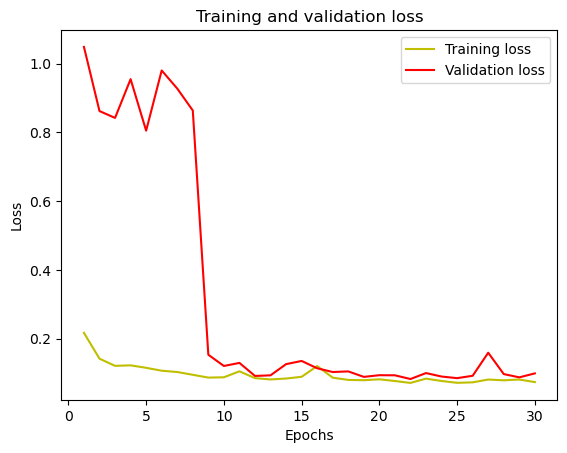

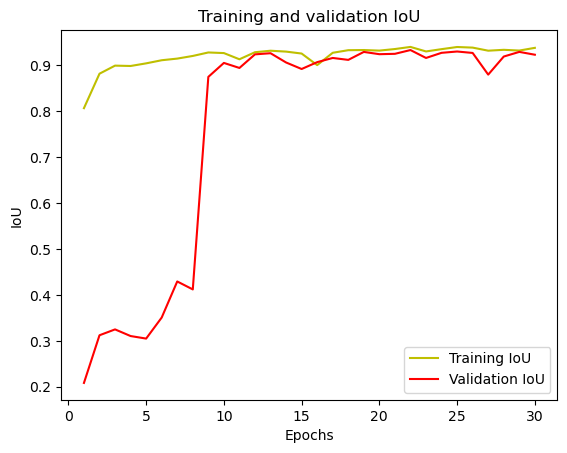

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Testing

In [11]:
from tensorflow import keras
model = keras.models.load_model('D:\documents\master_dataset_2\saved-model-30-unet_backbone_resnet34.hdf5', compile=False)
val_generator = image_mask_generator(*create_generator_pair(img_val_path, mask_val_path))

Found 449 images belonging to 1 classes.
Found 449 images belonging to 1 classes.


In [34]:
test_img_batch, test_mask_batch = next(val_generator)
model_predict = model.predict(test_img_batch)

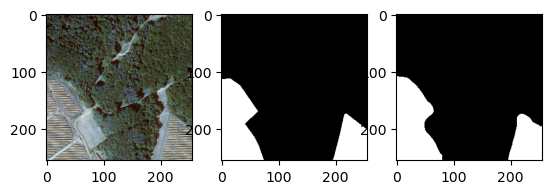

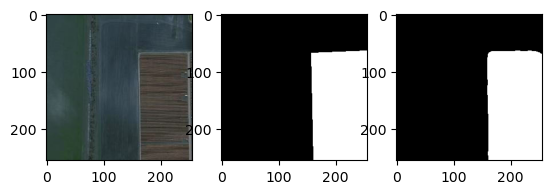

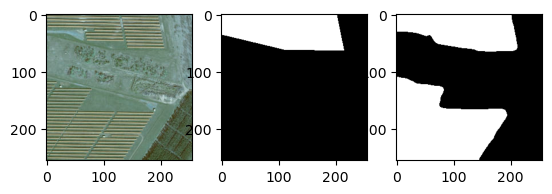

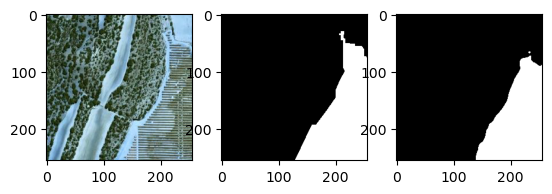

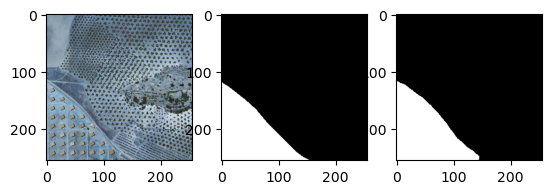

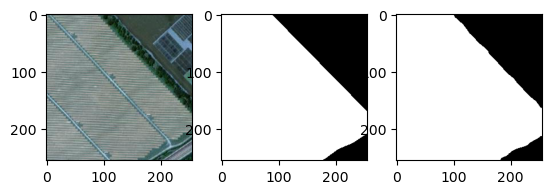

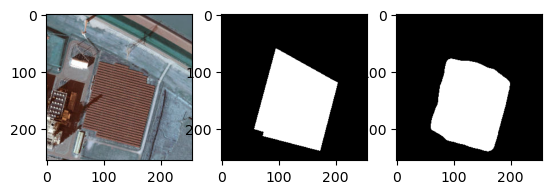

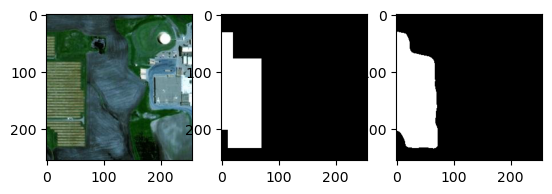

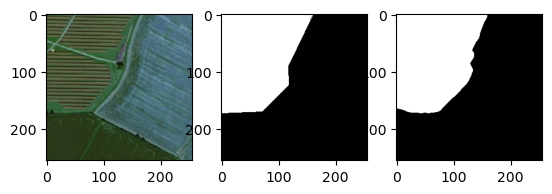

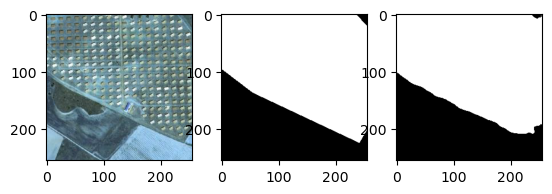

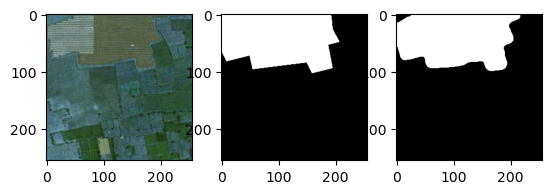

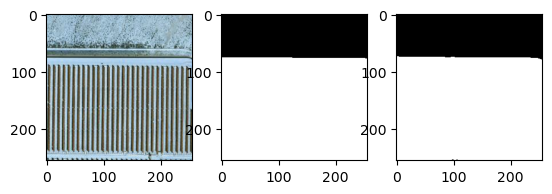

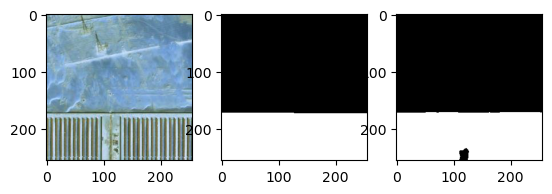

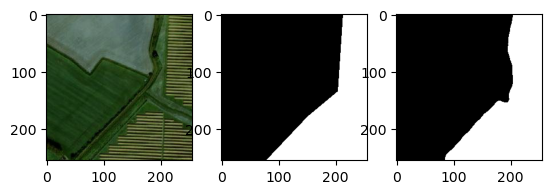

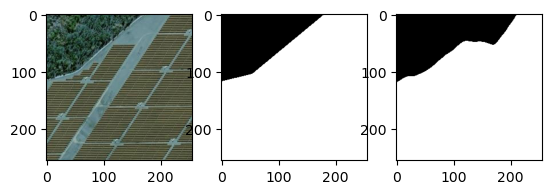

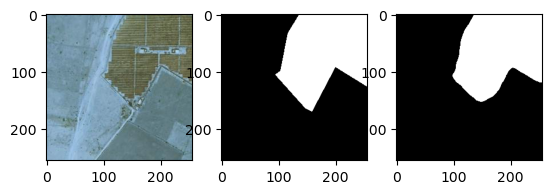

In [35]:
for img, mask, model_pred in zip(test_img_batch, np.argmax(test_mask_batch, axis=3), np.argmax(model_predict, axis=3)):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(model_pred, cmap='gray')
    plt.show()